# Initial protype of the Euler inversion code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd

## Make synthetic data

In [2]:
random = np.random.RandomState(0)

In [43]:
region = [0, 100e3, 0, 150e3]
height = 200
#coordinates = vd.scatter_points(region, size=1000, random_state=0, extra_coords=height)
coordinates = [i.ravel() for i in vd.grid_coordinates(region, shape=(30, 30), extra_coords=height)]
x, y, z = coordinates
prism = [40e3, 50e3, 60e3, 70e3, -10e3, 0]
density = 500
center = [(prism[1] + prism[0]) / 2, (prism[3] + prism[2]) / 2, (prism[5] + prism[4]) / 2]
print(center)
base_level = 3
gravity = hm.prism_gravity(coordinates, prism, density, field="g_z") + base_level
delta = 1
xderiv = (
    hm.prism_gravity((x + delta, y, z), prism, density, field="g_z")
    - hm.prism_gravity((x - delta, y, z), prism, density, field="g_z")
) / 2 * delta
yderiv = (
    hm.prism_gravity((x, y + delta, z), prism, density, field="g_z")
    - hm.prism_gravity((x, y - delta, z), prism, density, field="g_z")
) / 2 * delta
zderiv = (
    hm.prism_gravity((x, y, z + delta), prism, density, field="g_z")
    - hm.prism_gravity((x, y, z - delta), prism, density, field="g_z")
) / 2 * delta


#gravity += random.normal(loc=0, scale=0.2, size=gravity.size)
#xderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
#yderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
#zderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)

[45000.0, 65000.0, -5000.0]


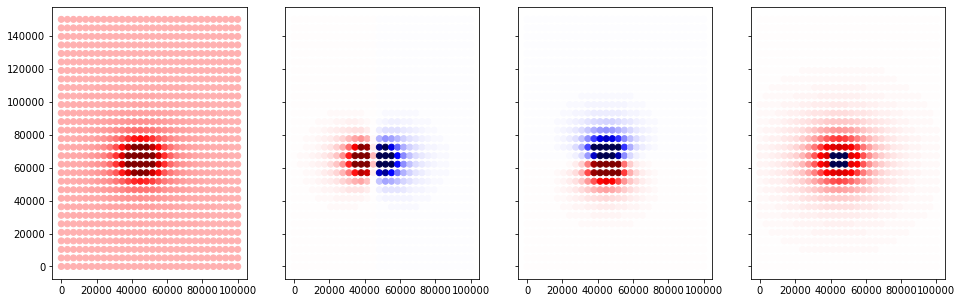

In [44]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

scale = 0.002
cmap = "seismic"

ax = axes[0]
ax.scatter(x, y, c=gravity, cmap=cmap, vmin=-20, vmax=20)

for ax, data in zip(axes[1:], [xderiv, yderiv, zderiv]):
    ax.scatter(x, y, c=data, cmap=cmap, vmin=-scale, vmax=scale)

## Calculate the matrices involved

In [45]:
def jacobian_parameters(xderiv, yderiv, zderiv, structural_index):
    """
    Calculate the model parameter Jacobian.
    """
    jacobian = np.empty((xderiv.size, 4))
    jacobian[:, 0] = -xderiv
    jacobian[:, 1] = -yderiv
    jacobian[:, 2] = -zderiv
    jacobian[:, 3] = -structural_index
    return jacobian

In [46]:
def jacobian_data(x, y, z, xo, yo, zo, structural_index):
    """
    Calculate the data Jacobian.
    """
    nequations = x.size
    ndata = nequations * 4
    diagonal = np.arange(nequations)
    jacobian = np.zeros((nequations, ndata))
    jacobian[diagonal, diagonal] = structural_index
    jacobian[diagonal, diagonal + nequations] = x - xo
    jacobian[diagonal, diagonal + nequations * 2] = y - yo
    jacobian[diagonal, diagonal + nequations * 3] = z - zo
    return jacobian

In [47]:
def eulers_equation(x, y, z, data, parameters, structural_index):
    """
    Evaluate Euler's equation.
    """
    nequations = x.size
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, baselevel = parameters
    euler = (
        (x - xo) * dx + (y - yo) * dy + (z - zo) * dz + structural_index * (h - baselevel)
    )
    return euler

In [48]:
def gauss_newton_step(parameters, data, coordinates, data_observed, Wd_inv, Wp, structural_index, damping):
    """
    Take a step in Gauss-Newton and return new parameters and data.
    """
    x, y, z = coordinates
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, base_level = parameters
    A = jacobian_parameters(dx, dy, dz, structural_index)
    B = jacobian_data(x, y, z, xo, yo, zo, structural_index)    
    r = data_observed - data
    f = eulers_equation(x, y, z, data, parameters, structural_index)
    Q = np.linalg.inv(B @ Wd_inv @ B.T)
    ATQ = A.T @ Q
    BTQ = B.T @ Q
    Br = B @ r
    Wd_invBTQ = Wd_inv @ BTQ
    deltap = np.linalg.solve(
        ATQ @ A + damping * Wp,
        -ATQ @ (f + Br)  #- damping * Wp @ parameters
    )
    deltad = r - Wd_invBTQ @ Br - Wd_invBTQ @ (f + A @ deltap)
    return deltap, deltad

In [49]:
def euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index, damping, maxit=100, tol=1e-5):
    """
    """
    region = vd.get_region(coordinates)
    data_observed = np.concatenate([field, xderiv, yderiv, zderiv])
    parameters = np.array([
        coordinates[0].min(),
        coordinates[1].min(),
        0,
        0,
    ])
    #parameters = np.zeros(4)
    data_predicted = np.zeros_like(data_observed)
    #data_predicted = np.copy(data_observed)
    wd = np.ones_like(data_observed)
    wd = np.concatenate([
        np.full_like(field, 1 / np.linalg.norm(field)**2),
        np.full_like(field, 1 / np.linalg.norm(xderiv)**2),
        np.full_like(field, 1 / np.linalg.norm(yderiv)**2),
        np.full_like(field, 1 / np.linalg.norm(zderiv)**2),
    ])
    wp = np.ones_like(parameters)
    #for i in range(3):
    #    wp[i] =  np.linalg.norm(field)**2 / np.mean(coordinates[0]) ** 2
    print("Data weights:", wd)
    print("Parameter weights:", wp)
    Wd_inv = np.linalg.inv(np.diag(wd))
    Wp = np.diag(wp)
    misfit = np.linalg.norm(eulers_equation(*coordinates, data_observed, parameters, structural_index))
    for i in range(maxit):
        deltap, deltad = gauss_newton_step(
            parameters, data_predicted, coordinates, data_observed, Wd_inv, Wp, structural_index, damping,
        )
        parameters += deltap
        data_predicted += deltad
        new_misfit = np.linalg.norm(eulers_equation(*coordinates, data_observed, parameters, structural_index))
        print("delta_p:", deltap, "| misfit: {:.2f}".format(new_misfit))
        if (new_misfit > misfit) or (np.abs(misfit - new_misfit) / misfit < tol):
            break
        misfit = new_misfit
    field_pred, dx_pred, dy_pred, dz_pred = np.split(data_predicted, 4)
    return parameters, field_pred, dx_pred, dy_pred, dz_pred

In [50]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=3, 
    damping=1e-10, 
    maxit=100,
    tol=1e-5,
)

Data weights: [1.99660485e-05 1.99660485e-05 1.99660485e-05 ... 5.35428544e+02
 5.35428544e+02 5.35428544e+02]
Parameter weights: [1. 1. 1. 1.]
delta_p: [0.        0.        0.        4.0654935] | misfit: 1614.03
delta_p: [ 9.19783203e+03  1.07194867e+04 -1.45576146e+04 -1.67404922e-01] | misfit: 1218.41
delta_p: [ 9.52416719e+03  1.31011617e+04  8.99377302e+02 -1.49803201e-02] | misfit: 911.66
delta_p: [ 1.46518237e+04  2.03478916e+04 -2.59705636e+03 -1.28215629e-01] | misfit: 495.12
delta_p: [ 9.93306651e+03  1.65513780e+04  5.41297586e+03 -3.18486207e-02] | misfit: 147.29
delta_p: [8.54720052e+02 2.61430851e+03 6.74995052e+02 2.50346506e-02] | misfit: 130.24
delta_p: [1.24842494e+02 4.28867982e+02 1.49635011e+02 5.56153013e-03] | misfit: 129.34
delta_p: [2.73918146e+01 1.06268161e+02 2.61112616e+01 1.57966018e-03] | misfit: 129.26
delta_p: [5.46576307e+00 2.37628557e+01 4.54385528e+00 2.67235618e-04] | misfit: 129.25
delta_p: [1.13393913e+00 5.46948956e+00 8.41941450e-01 4.44541626e

In [51]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

44320.7 63899.8 -9986.0 3.8
45000.0 65000.0 -5000.0 3.0


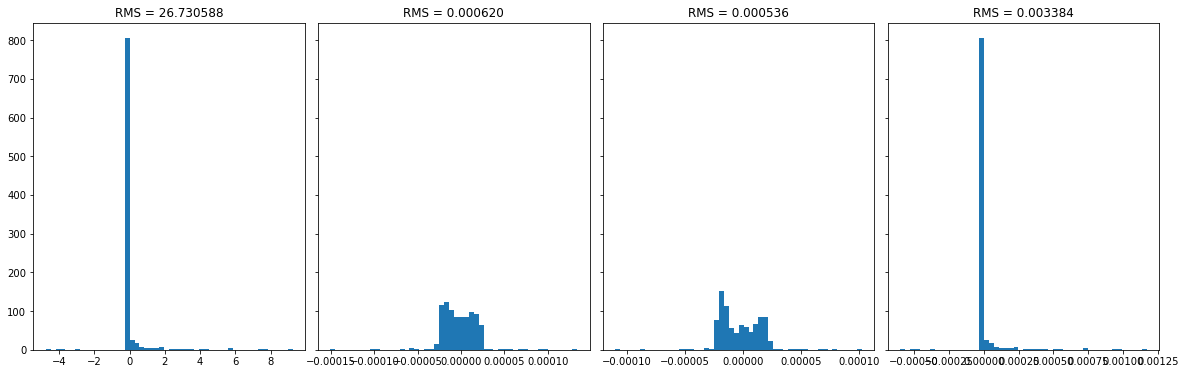

In [52]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

In [53]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=1, 
    damping=1e-10, 
    maxit=100,
    tol=1e-5,
)

Data weights: [1.99660485e-05 1.99660485e-05 1.99660485e-05 ... 5.35428544e+02
 5.35428544e+02 5.35428544e+02]
Parameter weights: [1. 1. 1. 1.]
delta_p: [0.         0.         0.         3.77425953] | misfit: 1537.32
delta_p: [ 1.74358486e+03  1.56910683e+03 -7.38614800e+03 -8.96869265e-02] | misfit: 1461.10
delta_p: [ 1.81923924e+03  2.28661713e+03 -4.33224094e+02  4.67354133e-02] | misfit: 1405.67
delta_p: [ 3.40234999e+03  3.84732548e+03 -5.23436499e+03 -1.12267968e-01] | misfit: 1336.38
delta_p: [ 3.46632899e+03  4.53349721e+03  4.41360682e+00 -1.69065819e-01] | misfit: 1233.22
delta_p: [ 5.18492736e+03  6.64841254e+03 -2.21089211e+03 -2.24040512e-01] | misfit: 1115.43
delta_p: [ 5.80800940e+03  8.27058616e+03  1.75359538e+03 -2.25365752e-01] | misfit: 919.25
delta_p: [ 8.62114909e+03  1.27314261e+04  2.08131334e+03 -3.23809983e-01] | misfit: 637.18
delta_p: [ 1.22121436e+04  2.00315645e+04  7.18000598e+03 -7.50938162e-01] | misfit: 153.45
delta_p: [ 3.96871692e+03  7.64335365e+03 

In [54]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

44756.6 64817.5 -2595.3 -0.9
45000.0 65000.0 -5000.0 3.0


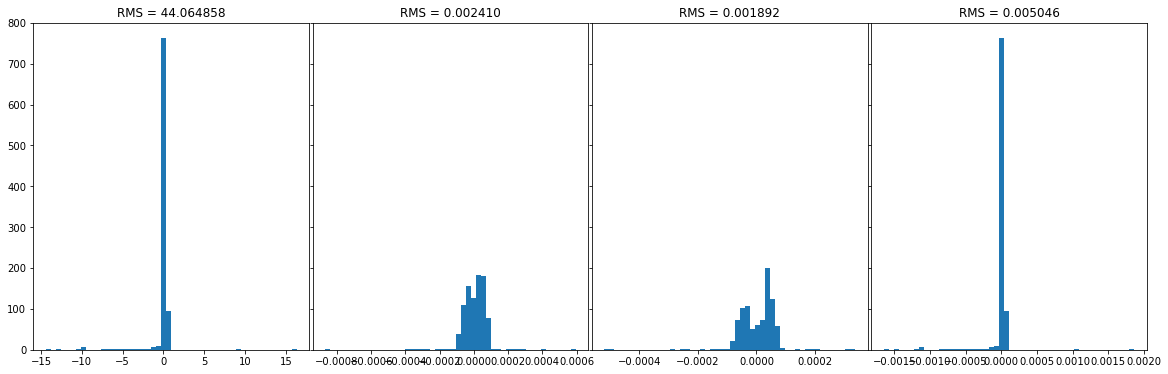

In [55]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

In [56]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=2, 
    damping=1e-10, 
    maxit=100,
    tol=1e-3,
)

Data weights: [1.99660485e-05 1.99660485e-05 1.99660485e-05 ... 5.35428544e+02
 5.35428544e+02 5.35428544e+02]
Parameter weights: [1. 1. 1. 1.]
delta_p: [0.         0.         0.         3.95617246] | misfit: 1565.21
delta_p: [ 5.29983227e+03  5.94872370e+03 -1.09093984e+04 -1.45224243e-01] | misfit: 1340.87
delta_p: [5.68301913e+03 7.67468706e+03 1.77709282e+02 5.82994682e-03] | misfit: 1158.89
delta_p: [ 1.04156853e+04  1.35998019e+04 -4.77590166e+03 -1.50834210e-01] | misfit: 880.79
delta_p: [ 1.20994444e+04  1.80206366e+04  4.38277375e+03 -1.63032276e-01] | misfit: 449.61
delta_p: [ 1.34846032e+04  2.20174167e+04  4.93552716e+03 -2.51820603e-01] | misfit: 91.50
delta_p: [-2.65312645e+03 -3.32999676e+03 -1.93319011e+02 -7.79816246e-02] | misfit: 56.03
delta_p: [ 2.43423968e+02  4.31676354e+02  2.07671571e+02 -4.19612037e-03] | misfit: 54.08
delta_p: [-8.53113088e+00  6.91756355e+00 -5.61788059e+00 -3.28469423e-04] | misfit: 54.09
CPU times: user 1min 2s, sys: 9.77 s, total: 1min 12s

In [57]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

44564.4 64369.9 -6180.6 3.2
45000.0 65000.0 -5000.0 3.0


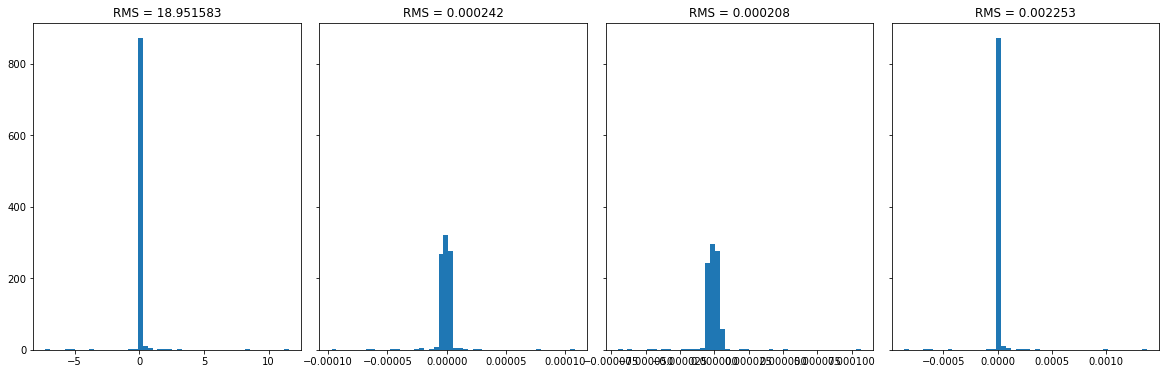

In [58]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

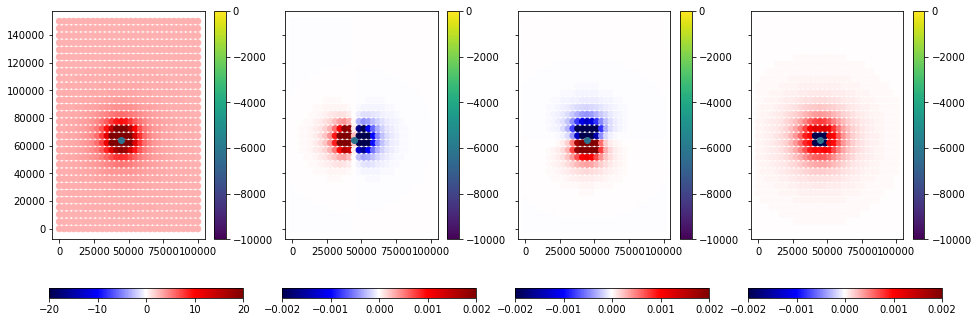

In [59]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"

ax = axes[0]
tmp = ax.scatter(x, y, c=h, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")